In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('delhivery_data.csv')

#converting time column to date time.
df['od_start_time'] = pd.to_datetime(df['od_start_time'], errors='coerce')
df['od_end_time'] = pd.to_datetime(df['od_end_time'], errors='coerce')

#drop rows with missing critical values.
df = df.dropna(subset=['segment_actual_time', 'segment_osrm_time', 'actual_distance_to_destination', 'factor'])

#calculating delay
df['delay_minutes'] = df['segment_actual_time'] - df['segment_osrm_time']
df['is_delayed'] = (df['delay_minutes'] > 15).astype(int)
print(df)

            data          trip_creation_time  \
0       training  2018-09-20 02:35:36.476840   
1       training  2018-09-20 02:35:36.476840   
2       training  2018-09-20 02:35:36.476840   
3       training  2018-09-20 02:35:36.476840   
4       training  2018-09-20 02:35:36.476840   
...          ...                         ...   
144862  training  2018-09-20 16:24:28.436231   
144863  training  2018-09-20 16:24:28.436231   
144864  training  2018-09-20 16:24:28.436231   
144865  training  2018-09-20 16:24:28.436231   
144866  training  2018-09-20 16:24:28.436231   

                                      route_schedule_uuid route_type  \
0       thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
1       thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
2       thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
3       thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
4       thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Ca

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   data                            144867 non-null  object        
 1   trip_creation_time              144867 non-null  object        
 2   route_schedule_uuid             144867 non-null  object        
 3   route_type                      144867 non-null  object        
 4   trip_uuid                       144867 non-null  object        
 5   source_center                   144867 non-null  object        
 6   source_name                     144574 non-null  object        
 7   destination_center              144867 non-null  object        
 8   destination_name                144606 non-null  object        
 9   od_start_time                   144867 non-null  datetime64[ns]
 10  od_end_time                     144867 non-null  datetim

In [13]:
df.describe()

,od_start_time,od_end_time,start_scan_to_end_scan,cutoff_factor,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor,delay_minutes,is_delayed
count,144867,144867,144867.000000,144867.000000,144867.000000,144867.000000,144867.000000,144867.000000,144867.000000,144867.000000,144867.000000,144867.00000,144867.000000,144867.000000,144867.000000
mean,2018-09-22 18:02:45.855230720,2018-09-23 10:04:31.395393024,961.262986,232.926567,234.073372,416.927527,213.868272,284.771297,2.120107,36.196111,18.507548,22.82902,2.218368,17.688563,0.330365
min,2018-09-12 00:00:16.535741,2018-09-12 00:50:10.814399,20.000000,9.000000,9.000045,9.000000,6.000000,9.008200,0.144000,-244.000000,0.000000,0.00000,-23.444444,-274.000000,0.000000
25%,2018-09-17 08:05:40.886155008,2018-09-18 01:48:06.410121984,161.000000,22.000000,23.355874,51.000000,27.000000,29.914700,1.604264,20.000000,11.000000,12.07010,1.347826,5.000000,0.000000
50%,2018-09-22 08:53:00.116656128,2018-09-23 03:13:03.520212992,449.000000,66.000000,66.126571,132.000000,64.000000,78.525800,1.857143,29.000000,17.000000,23.51300,1.684211,10.000000,0.000000
75%,2018-09-27 22:41:50.285857024,2018-09-28 12:49:06.054018048,1634.000000,286.000000,286.708875,513.000000,257.000000,343.193250,2.213483,40.000000,22.000000,27.81325,2.250000,19.000000,1.000000
max,2018-10-06 04:27:23.392375,2018-10-08 03:00:24.353479,7898.000000,1927.000000,1927.447705,4532.000000,1686.000000,2326.199100,77.387097,3051.000000,1611.000000,2191.40370,574.250000,2418.000000,1.000000
std,NaN,NaN,1037.012769,344.755577,344.990009,598.103621,308.011085,421.119294,1.715421,53.571158,14.775960,17.86066,4.847530,49.010556,0.470346


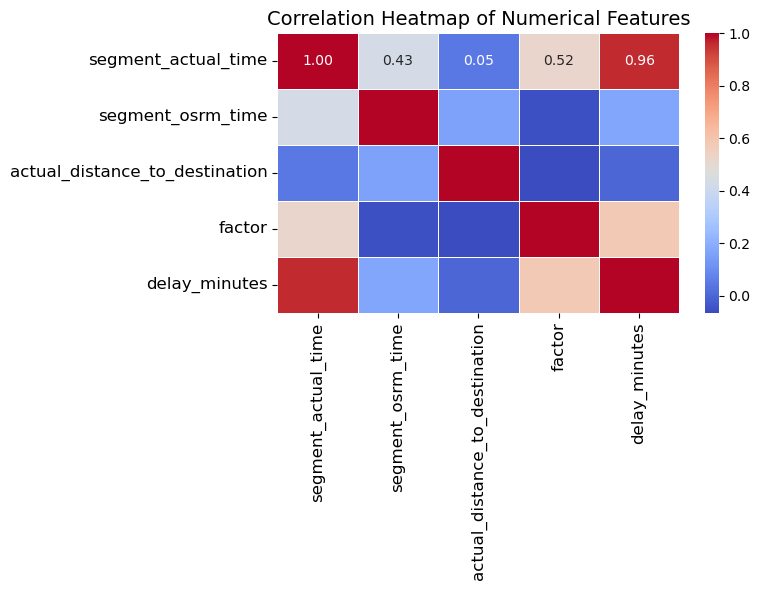

In [11]:
numeric_cols = ['segment_actual_time', 'segment_osrm_time', 'actual_distance_to_destination', 'factor', 'delay_minutes']
corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300)
plt.show()
plt.close()

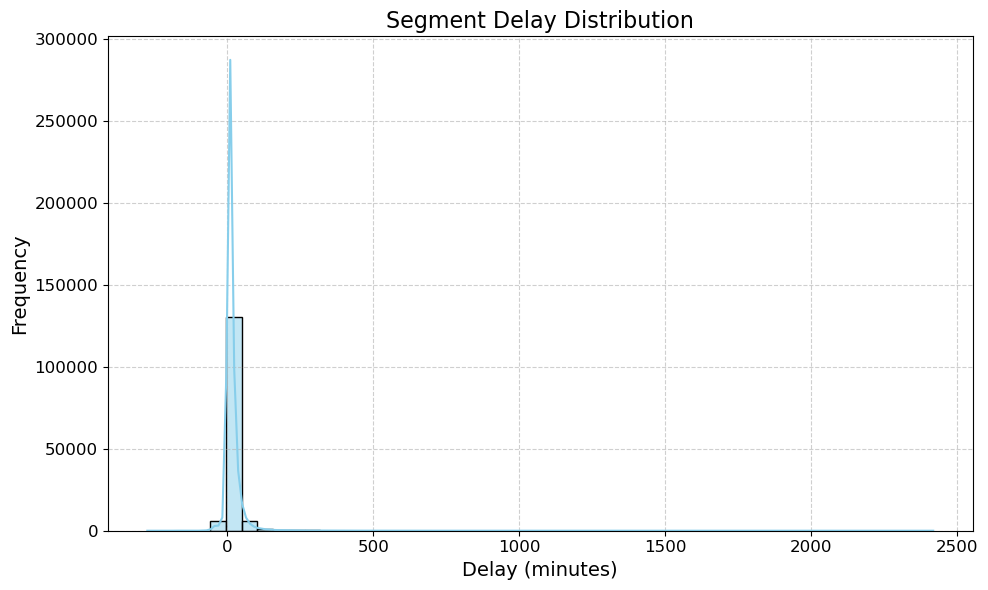

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(df['delay_minutes'], bins=50, kde=True, color='skyblue', edgecolor='black')
plt.title('Segment Delay Distribution', fontsize=16)
plt.xlabel('Delay (minutes)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('delay_distribution_cleaned.png', dpi=300)
plt.show()
plt.close()

In [3]:
x = df[['route_type', 'source_name', 'destination_name', 'actual_distance_to_destination', 'factor']] #x is independent variable.
y = df['is_delayed'] #y is dependent variable.
categorical_cols = ['route_type', 'source_name', 'destination_name'] #categorical columns.
numerical_cols = ['actual_distance_to_destination', 'factor'] #numerical columns.

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) #splitting train and test.
pipeline.fit(x_train, y_train) #training the model.
y_pred = pipeline.predict(x_test) #predicting and evaluating.
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86     19398
           1       0.74      0.65      0.69      9576

    accuracy                           0.81     28974
   macro avg       0.79      0.77      0.78     28974
weighted avg       0.80      0.81      0.81     28974



In [4]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[17144  2254]
 [ 3304  6272]]


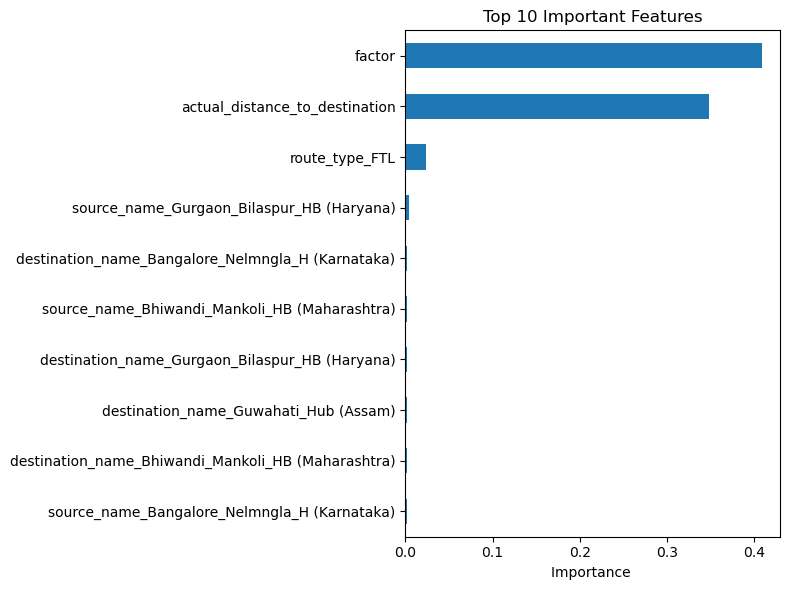

In [5]:
a = pipeline.named_steps['preprocessor'].named_transformers_['cat']
encoded_feature_names = a.get_feature_names_out(categorical_cols)
feature_names = list(encoded_feature_names) + numerical_cols
importances = pd.Series(pipeline.named_steps['classifier'].feature_importances_, index=feature_names) #it gives top 10 feature which is important in case of delay.

#ploting 10 features that will influence the delay.
plt.figure(figsize=(8, 6))
importances.nlargest(10).sort_values().plot(kind='barh')
plt.title('Top 10 Important Features')
plt.xlabel('Importance ')
plt.tight_layout()
plt.show()
plt.savefig('feature_importance.png')
plt.close()